# Project 03: Walmart Sales
## Bloc n°3 - Jedha - dsmft - Paris14
### Nicolas Hegerle

## Library imports and function definition

### <ins>Import the necessary libraries for the project</ins>

In [1]:
#Import the necessary libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.renderers.default = 'vscode'

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score

import statsmodels.api as sm

### <ins>Function definition</ins>

In [2]:
def remove_outliers(df, column, ts = 3):
    """
    Removes the rows where outliers are found in the specified columns of the dataframe (df) based on the desired threshold (ts)
    Removes all rows where col.mean() + ts * col.std() < row value < col.mean() - ts * col.std()

    Arguments:
    df: pandas dataframe, the dataframe you want to transform
    columns: string, the name of the column you want to apply the transformation to
    ts: integer, the threshold you want to use to remove outliers

    Returns:
    your df minus the rows where outliers were removed
    
    """

    col_mean = df[column].mean()
    col_std = df[column].std()

    low = col_mean - (ts * col_std)
    high = col_mean + (ts * col_std)

    mask_1 = df[column] >= low # true if value is higher than the lower limit
    mask_2 = df[column] <= high # true if value is lower than the higher limit
    mask_3 = df[column].isna() # true if value is nan => will be delt with during preprocessing before training

    df_out = df.loc[((mask_1) & (mask_2)) | mask_3] #keeps all rows for which values are higher than low AND lower than high OR are null
    
    return df_out

## Part I: data loading and exploration

### <ins>Load the dataset and print basic statistics</ins>

In [3]:
# read csv file into pandas dataframe
data = pd.read_csv('Walmart_Store_sales.csv')

#Print some information about the data
print(f"The shape of the data is {data.shape[0]} rows and {data.shape[1]} columns")

print("\nBasic statistics of the dataset: ")
display(data.describe(include = 'all'))

print("\nFirst 5 lines of the dataset:")
display(data.head())

print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])
print()


The shape of the data is 150 rows and 8 columns

Basic statistics of the dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



First 5 lines of the dataset:


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

- <font size = 5>Only a 150 rows. Not much data to work with...</font>
- <font size = 5>CPI = consumer price index. Estimation of the avg variation between two given periods in the prices of products consumed by households. CPI = basket cost at time t / basket cost at baseline * 100</font>
- <font size = 5>temps are in °F. US standards</font>
- <font size = 5>No feature has too many missing values that it requires dropping the column</font>

In [4]:
# lets change column names to lower case and convert date column to datetime object
data = data.rename(str.lower, axis = 'columns')
data = data.rename(columns = {'holiday_flag': 'holidays', 'temperature':'temp', 'fuel_price':'fuel'})
data['date'] = pd.to_datetime(data['date'])

# lets extract the week of the year from the date time column since we are working with weekly sales
data['weekofyear'] = data['date'].dt.weekofyear

display(data.head())


print("\nInformation about the data:")
display(data.info())

/var/folders/16/4bnr3kp950g2168ghl5qt2v00000gn/T/ipykernel_81388/2925799786.py:7: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,store,date,weekly_sales,holidays,temp,fuel,cpi,unemployment,weekofyear
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,7.0
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,12.0
2,17.0,2012-07-27,NaN,0.0,NaN,NaN,130.719581,5.936,30.0
3,11.0,NaT,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,21.0



Information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store         150 non-null    float64       
 1   date          132 non-null    datetime64[ns]
 2   weekly_sales  136 non-null    float64       
 3   holidays      138 non-null    float64       
 4   temp          132 non-null    float64       
 5   fuel          136 non-null    float64       
 6   cpi           138 non-null    float64       
 7   unemployment  135 non-null    float64       
 8   weekofyear    132 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 10.7 KB


None

In [5]:
# lets drop lines where target value (weekly-sales) is missing
print(f"Number of lines where weekly_sales = Nan to drop: {data['weekly_sales'].isnull().sum()}")
print(f"Number of rows before droping the lines : {data.shape[0]}")
print("Droping lines where weekly_sales is NaN...")
data.dropna(subset = ['weekly_sales'], inplace = True)
data.reset_index(inplace = True, drop = True)
print(f"...dropped the lines. Number of remaining rows is: {data.shape[0]}.")
print()



Number of lines where weekly_sales = Nan to drop: 14
Number of rows before droping the lines : 150
Droping lines where weekly_sales is NaN...
...dropped the lines. Number of remaining rows is: 136.



In [6]:
# lets check for the outliers in the features
fig = make_subplots(rows = 1, cols = 4, subplot_titles = ('temp', 'fuel', 'cpi', 'unemployment'))

features = ['temp', 'fuel', 'cpi', 'unemployment']
column = 1

for feature in features:
    fig.add_trace(
        go.Box( y = data[feature]),
            row = 1,
            col = column) 
    column +=1

fig.update_layout(
        title = go.layout.Title(text = "Looking for outliers", x = 0.5),
        showlegend = False)

fig.show()

In [7]:
# determine the number of outliers to remove per column
# for this project is considered an outlier any value above 3 std of the mean
for col in features: #see block above for the list of features
    low = data[col].mean() - 3 * data[col].std()
    high = data[col].mean() + 3 * data[col].std()
    print('The number of outliers in {} is {}'.format(col, data.loc[(data[col] <= low) | (data[col] >= high)].shape[0]))

The number of outliers in temp is 0
The number of outliers in fuel is 0
The number of outliers in cpi is 0
The number of outliers in unemployment is 5


In [8]:
print('Removing outliers from the unemployment column')
data = remove_outliers(data, 'unemployment', ts = 3)
print('...Done\n')

Removing outliers from the unemployment column
...Done



In [9]:
# checkig for outliers in the new data
print('Checking for remaining outliers:')
column_names = ['temp' , 'fuel', 'cpi', 'unemployment']
for column in column_names:

    col_mean = data[column].mean()
    col_std = data[column].std()

    low = col_mean - 3 * col_std
    high = col_mean + 3 * col_std

    mask_1 = data[column] <= low
    mask_2 = data[column] >= high

    nb_outliers = data.loc[mask_1 | mask_2].shape[0]

    print(f"The number of outliers in {column} is {nb_outliers}")

Checking for remaining outliers:
The number of outliers in temp is 0
The number of outliers in fuel is 0
The number of outliers in cpi is 0
The number of outliers in unemployment is 0


### <ins>Exploratory Data Analysis</ins>

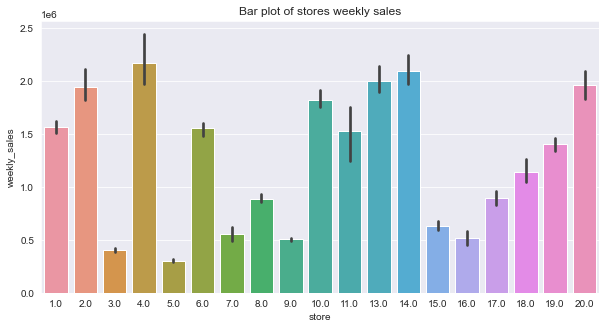

In [10]:
# bar plot of the stores weekly sales
sns.set_style('darkgrid')
plt.figure(figsize = (10, 5))
g = sns.barplot(data = data, x = 'store', y = 'weekly_sales')
g.set_title("Bar plot of stores weekly sales")
plt.show()

- <font size = 5>Great differences between stores average weekly sales</font>
- <font size = 5>Weekly salesa re in the 10^6$, lets change to log10 of that value</font>
- <font size = 5>Store id won't be used for the model</font>

In [11]:
# weekly sales are in the 10^6 => lets use the log10 of that value
data['weekly_sales'] = data['weekly_sales'].apply(lambda x : np.log10(x))
display(data.head())

,store,date,weekly_sales,holidays,temp,fuel,cpi,unemployment,weekofyear
0,6.0,2011-02-18,6.196485,NaN,59.61,3.045,214.777523,6.858,7.0
1,13.0,2011-03-25,6.257089,0.0,42.38,3.435,128.616064,7.470,12.0
2,11.0,NaT,6.094957,0.0,84.57,NaN,214.556497,7.346,NaN
3,6.0,2010-05-28,6.216026,0.0,78.89,2.759,212.412888,7.092,21.0
4,4.0,2010-05-28,6.268937,0.0,NaN,2.756,126.160226,7.896,21.0


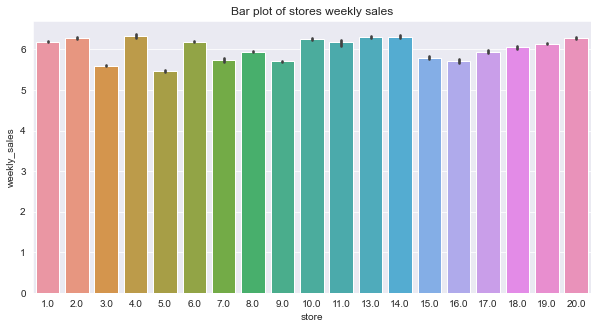

In [12]:
# bar plot of the log10 transformed stores weekly sales
sns.set_style('darkgrid')
plt.figure(figsize = (10, 5))
g = sns.barplot(data = data, x = 'store', y = 'weekly_sales')
g.set_title("Bar plot of stores weekly sales")
plt.show()

In [13]:
# distribution of the weekly sales
fig = px.histogram(data, x = 'weekly_sales', title = 'Distribution of the weekly sales')
fig.show()

- <font size = 5>Sort of a 'bell shaped' curve shifted towards higher values. Majority of weekly sales are between 10^6.2 and 10^6.3$</font>

In [14]:
# can we find any obvious correlation between weekly sales and the other features
# heatmap of the correlation matrix calcuated on the dataframe
cols_to_plot = [col for col in data.columns if (col != 'store') and (col != 'date')]
matrix = data[cols_to_plot].corr()
fig = px.imshow(matrix)
fig.show()

- <font size = 5>```cpi``` has the highest <ins>negative correlation</ins> with ```weekly_sales```, followed by ```temp```.</font>
- <font size = 5>```unemployment``` has the <ins>highest positive</ins> correlation=>walmart is a low cost store, makes sense.</font>
- <font size = 5>No strong inter correlation between features</font>

In [15]:
#Print a scatter matrix to see if their are any evident correlations between the numeric features and the target weekly sales
fig = px.scatter_matrix(data, dimensions = cols_to_plot, color = 'store')
fig.update_layout(
        title = go.layout.Title(text = "Bivariate analysis", x = 0.5), showlegend = False, 
            autosize=False, height=800, width = 1000)
fig.update_traces(diagonal_visible=False, showlowerhalf=False)
fig.show()

- <font size = 5>As expected, no obvious correlation between the features and the target</ins>

## Part II: linear regression to predict ```weekly_sales```

### <ins>Preprocessing of the features</ins>
 - Categorical variables : store, holidays
 - Numerical variables : temp, fuel, cpi, unemployment, weekofyear

In [16]:
# isolate the target variable and the features

to_drop = ['date', 'weekly_sales']
features = [c for c in data.columns if c not in to_drop]
target = 'weekly_sales'

X = data.loc[:, features]
X = X.values

print("Features for model training:")
print(X[:3], '\n')


y = data.loc[:, 'weekly_sales']
print("Target for model training:")
print(y[ :3], '\n')


Features for model training:
[[  6.                nan  59.61        3.045     214.7775231   6.858
    7.       ]
 [ 13.          0.         42.38        3.435     128.6160645   7.47
   12.       ]
 [ 11.          0.         84.57              nan 214.5564968   7.346
          nan]] 

Target for model training:
0    6.196485
1    6.257089
2    6.094957
Name: weekly_sales, dtype: float64 



In [17]:
# dividing the dataset into train set & test set
print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print('...Done')
print(f"X_train shape : {X_train.shape} / X_test shape: {X_test.shape} / y_train shape: {y_train.shape} / y_test shape: {y_test.shape}")

Dividing into train and test sets...
...Done
X_train shape : (98, 7) / X_test shape: (33, 7) / y_train shape: (98,) / y_test shape: (33,)


In [18]:
# creating the pipeline for numeric features: unemployment, cpi, temp, weekofyear
numeric_features = [2, 3, 4, 5, 6]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), #missing values will be replaced by columns' median
    ('scaler', StandardScaler()) #normalize the values of the columns
])

In [19]:
# Create pipeline for categorical features: store and holidays
categorical_features = [0, 1] #Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [20]:
# make a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ])

In [21]:
# fit the preprocessor on the train set and transform it
print("Performing preprocessings on train set...")
print(X_train[:3, :])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[:3, :], '\n')

Performing preprocessings on train set...
[[ 13.          0.         36.78        2.817     126.7934      7.795
   41.       ]
 [ 13.          0.         32.71              nan 130.2792258   6.104
    3.       ]
 [ 16.          0.         48.29        3.75      197.4133259   6.162
   13.       ]]
...Done.
  (0, 10)	1.0
  (0, 19)	-1.3778859263796914
  (0, 20)	-1.1530633525470637
  (0, 21)	-1.4798248355117645
  (0, 22)	0.4462966142605368
  (0, 23)	0.9993307248014697
  (1, 10)	1.0
  (1, 19)	-1.6213251757510556
  (1, 20)	0.35828772100219347
  (1, 21)	-1.3865212277123211
  (1, 22)	-1.3733014352899144
  (1, 23)	-1.6993695066420926
  (2, 13)	1.0
  (2, 19)	-0.6894373366341389
  (2, 20)	0.8816993482054001
  (2, 21)	0.4104285067520397
  (2, 22)	-1.310890621053411
  (2, 23)	-0.9891852352095764 



In [22]:
# transform the test set with the fitted preprocessor
print("Performing preprocessings on test set...")
print(X_test[:3])
X_test = preprocessor.transform(X_test)
print('...Done.')
print(X_test[:3], '\n')

Performing preprocessings on test set...
[[  3.          0.         60.12        3.555     224.1320199   6.833
          nan]
 [  3.          0.         45.71        2.572     214.4248812   7.368
   17.       ]
 [ 18.          0.         69.75        3.815     135.4468      8.89
          nan]]
...Done.
  (0, 1)	1.0
  (0, 19)	0.018151439794174655
  (0, 20)	0.45642740110279545
  (0, 21)	1.1255963576209382
  (0, 22)	-0.5888620632483557
  (0, 23)	-0.13696410949055662
  (1, 1)	1.0
  (1, 19)	-0.8437550917638977
  (1, 20)	-1.6873793886503368
  (1, 21)	0.8657695291777023
  (1, 22)	-0.013176104342683386
  (1, 23)	-0.7051115266365697
  (2, 15)	1.0
  (2, 19)	0.5941514327785079
  (2, 20)	1.0234566639062683
  (2, 21)	-1.248202980015799
  (2, 22)	1.624569745104857
  (2, 23)	-0.13696410949055662 



### <ins>Training the model and performance evaluation </ins>

In [23]:
#Perform cross validation on the train set
regressor = LinearRegression()
scores = cross_val_score(regressor, X_train, y_train, cv=5)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())
print()


The cross-validated R2-score is :  0.966096821864301
The standard deviation is :  0.012966012237124586



- <font size = 5>That looks pretty good!!! Lets move on

In [24]:
# train the linear regression model
print("Training model")
regressor.fit(X_train, y_train)
print('...Done')
print()

# make predictions and print r-2 score on the train set
print("Predicting on y_train...")
y_train_pred_linreg = regressor.predict(X_train)
print("...Done for y_train.")
print("R2 score on train set: ", round(r2_score(y_train, y_train_pred_linreg), 3))
print()

# make predictions and print r-2 score on the test set
print("Predicting on y_test...")
y_test_pred_linreg = regressor.predict(X_test)
print("...Done for y_test.")
print("R2 score on test set: ", round(r2_score(y_test, y_test_pred_linreg), 3))

Training model
...Done

Predicting on y_train...
...Done for y_train.
R2 score on train set:  0.985

Predicting on y_test...
...Done for y_test.
R2 score on test set:  0.971


<font size = 5>
- R2 score of the test set is within the standard deviation of the cross-val scores for the train set. <br>
- Lets see the feature impotance

In [25]:
# retrieve categorical feature names
cat_feat_names = list(preprocessor.transformers_[0][1].named_steps['encoder'].get_feature_names(['store', 'holiday']))
no_keep = ['weekly_sales', 'store', 'holidays', 'date']
num_feat_names = [c for c in data.columns if c not in no_keep]
feat_names = cat_feat_names + num_feat_names
print(feat_names, '\n')

['store_2.0', 'store_3.0', 'store_4.0', 'store_5.0', 'store_6.0', 'store_7.0', 'store_8.0', 'store_9.0', 'store_10.0', 'store_11.0', 'store_13.0', 'store_14.0', 'store_15.0', 'store_16.0', 'store_17.0', 'store_18.0', 'store_19.0', 'store_20.0', 'holiday_1.0', 'temp', 'fuel', 'cpi', 'unemployment', 'weekofyear'] 



/Users/nhegerle/miniforge3/envs/walmartsales/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [26]:
# print the coefficients for each feature
data_dict = {'coefficients' : regressor.coef_, 'abs_coeff': abs(regressor.coef_)}
df_coef = pd.DataFrame(data = data_dict, index = feat_names)
df_coef = df_coef.sort_values(by = 'abs_coeff', ascending = False)
df_coef

,coefficients,abs_coeff
store_5.0,-0.764193,0.764193
store_3.0,-0.620265,0.620265
store_9.0,-0.548511,0.548511
store_16.0,-0.491042,0.491042
store_7.0,-0.413796,0.413796
store_15.0,-0.280477,0.280477
store_8.0,-0.277041,0.277041
store_10.0,0.214595,0.214595
store_14.0,0.192398,0.192398
store_17.0,-0.191359,0.191359


<font size = 5>
- Individual stores have the highest coefficients, which doesn't really help us understand what external factors impact weekly sales <br>
- It tells us that stores 5, 3, 9, 16, 7, 15, 8 drive the weekly sales down and we should maybe focus on how to improve that for example <br>
- Fuel, holidays, temp weekofyear and cpi play minor parts in the weekly sells according to this model

### <ins>Alternative using StatsModel</ins>

In [27]:
# alternative method with statsmodels
x_names = ['const'] + feat_names
X = sm.add_constant(X_train.toarray()) # the coefficient beta_0 also called intercept is not automatically included, so we need to manually add a constant variable equal to one.
est = sm.OLS(y_train, X)
est2 = est.fit()
print("\n")
print("-----------------------------------------------------------------------------------------")
print("------------------------Results from statsmodels-----------------------------------------")
print("-----------------------------------------------------------------------------------------")
print("\n")
print(est2.summary(xname = x_names))



-----------------------------------------------------------------------------------------
------------------------Results from statsmodels-----------------------------------------
-----------------------------------------------------------------------------------------


                            OLS Regression Results                            
Dep. Variable:           weekly_sales   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     201.0
Date:                Sun, 19 Dec 2021   Prob (F-statistic):           3.58e-57
Time:                        12:05:02   Log-Likelihood:                 191.33
No. Observations:                  98   AIC:                            -332.7
Df Residuals:                      73   BIC:                            -268.0
Df Model:                          24                                         
Covariance Type

## Part III: regularized linear models

### <ins>Linear model with ridge regularization</ins>

In [28]:
print("Grid search with Ridge regressor...")
ridge_regressor = Ridge()

# grid of values to be tested
params = {
    'alpha': np.arange(0, 0.2, 0.0001) # 0 corresponds to no regularization <=> to a linear regression
}
gridsearch = GridSearchCV(ridge_regressor, param_grid = params, cv = 5) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameter : ", gridsearch.best_params_)
print("Mean best R2 scores : ", gridsearch.best_score_)
print("Standard deviation of the best scores: ", gridsearch.cv_results_['std_test_score'][gridsearch.best_index_])

Grid search with Ridge regressor...
...Done.
Best hyperparameter :  {'alpha': 0.011600000000000001}
Mean best R2 scores :  0.9660198806559533
Standard deviation of the best scores:  0.013887678184563544


In [29]:

# lets check model perofmance
# on training set
y_train_pred_ridge = gridsearch.predict(X_train)
print(f"R2 score on the train set: {round(r2_score(y_train, y_train_pred_ridge), 3)}")

# on test set
y_test_pred_ridge = gridsearch.predict(X_test)
print(f"R2 score on the test set: {round(r2_score(y_test, y_test_pred_ridge), 3)}")

R2 score on the train set: 0.985
R2 score on the test set: 0.972


In [30]:
# check improvement

delta_linreg = r2_score(y_train, y_train_pred_linreg) - r2_score(y_test, y_test_pred_linreg)
delta_ridge = r2_score(y_train, y_train_pred_ridge) - r2_score(y_test, y_test_pred_ridge)
if delta_ridge < delta_linreg:
    print("Overfitting was reduced by the regularization")
else:
    print("Regularization did not reduce the overfitting")

print(f"R2_train - R2_test for linear regression is : {round(delta_linreg, 4)}")
print(f"R2_train - R2_test for linear ridge regression is : {round(delta_ridge, 4)}")


Overfitting was reduced by the regularization
R2_train - R2_test for linear regression is : 0.0142
R2_train - R2_test for linear ridge regression is : 0.0134


<font size = 5>
- Minor improvement compared to the regular linear model

In [31]:
# coefficients obtained for the best parameters with ridge regression
ridge_coef = gridsearch.best_estimator_.coef_
abs_ridge_coef = abs(ridge_coef)
df_coef['ridge_coef'] = ridge_coef
df_coef['abs_ridge_coef'] = abs_ridge_coef
display(df_coef)

,coefficients,abs_coeff,ridge_coef,abs_ridge_coef
store_5.0,-0.764193,0.764193,0.104032,0.104032
store_3.0,-0.620265,0.620265,-0.612445,0.612445
store_9.0,-0.548511,0.548511,0.191217,0.191217
store_16.0,-0.491042,0.491042,-0.754084,0.754084
store_7.0,-0.413796,0.413796,-0.012985,0.012985
store_15.0,-0.280477,0.280477,-0.410031,0.410031
store_8.0,-0.277041,0.277041,-0.268599,0.268599
store_10.0,0.214595,0.214595,-0.536294,0.536294
store_14.0,0.192398,0.192398,0.219190,0.219190
store_17.0,-0.191359,0.191359,0.010109,0.010109


<font size = 5>
- Lasso does not improve anything and is not presented

## <ins>Conclusion and perspectives</ins>

<font size = 5>
- Regularization does not improve Linear regression model by much <br>
- Features with the most importance are the stores themselves <br>
- Could be interesting to cluster stores per weekly sales and see if different features have different importance depending on the store's income